# Generate the files

## Requirements

[rustup](https://rustup.rs/)
[python3](https://www.python.org/downloads/)

Maybe virtual env?

## Step by Step
We need to locate the directory where the replays are, in my case I dual-boot and mount windows to `/mnt/windows`

The final step takes around 32 seconds to process 3600 Replay files. This means about 110 replays per-second on a 16 Core machine.
```bash
$ git clone https://github.com/sebosp/s2protocol-rs
$ cd s2protocol-rs
$ mkdir ipcs/
$ cargo run --features arrow -r -- --timing --source "/mnt/windows/Users/sebos/Documents/StarCraft II/Accounts/51504154/2-S2-1-8459957/Replays/Multiplayer/" --output ipcs/ write-arrow-ipc all'
$ cd ipcs
$ du -sh *
3.8M    details.ipc
27M     init_data.ipc
441M    stats.ipc
3.3G    unit_born.ipc
2.4G    unit_died.ipc
37M     upgrades.ipc
$ cd ..
$ pip install -r requirements.txt
$ jupyter lab --notebook-dir=jupyter_notebooks/
# Open the URL explained in the terminal, this will open this notebook for interacting with the data.
```


In [298]:
# import datashader as ds
import plotly.express as px
import polars as pl
from functime.cross_validation import train_test_split
from functime.forecasting import linear_model
from functime.metrics import mase
from functime.preprocessing import scale
from functime.seasonality import add_calendar_effects, add_fourier_terms

pl.Config.set_tbl_width_chars(256)
pl.Config.set_fmt_str_lengths(256)

# In this case I'm interested in my own user data.
my_username = "2-1-8459957-Sazed"

unit_born_df = pl.scan_ipc("/home/seb/git/s2protocol-rs/ipcs/unit_born.ipc")
unit_died_df = pl.scan_ipc("/home/seb/git/s2protocol-rs/ipcs/unit_died.ipc")
stats_df = pl.scan_ipc("/home/seb/git/s2protocol-rs/ipcs/stats.ipc")
upgrades_df = pl.scan_ipc("/home/seb/git/s2protocol-rs/ipcs/upgrades.ipc")

details_df = pl.scan_ipc("/home/seb/git/s2protocol-rs/ipcs/details.ipc")
# Explode the details_df so we get a row per player.
details_df_exp = (
    details_df.explode("player_list")
    .unnest("player_list")
    .unnest("toon")
    # id 0 seems to be only for AI
    .filter(pl.col("id") != 0)
    # .filter(pl.col("name").str.ends_with("Sazed"))
    .select(
        [
            pl.col("region"),
            pl.col("realm"),
            pl.col("id"),
            pl.col("working_set_slot_id") + 1,
            pl.col("ext_fs_replay_sha256"),
            pl.col("ext_datetime"),
            pl.col("name").str.split(by="<sp/>").list.last(),
        ]
    )
)

latest_replay_digest = (
    details_df_exp.collect()
    .sort("ext_datetime", descending=True)
    .select(pl.col("ext_fs_replay_sha256"))
    .limit(1)
)
details_df_exp.collect().schema

# To find your user, you can inspect a replay, for example the latest one, this is a combination of the blizzard ids, region, etc.
# unit_born_df.join(details_df_exp, left_on=[
#        pl.col("ext_fs_replay_sha256"), pl.col("player_id"),
#    ], right_on = [
#        pl.col("ext_fs_replay_sha256"), pl.col("working_set_slot_id"),
#    ])
# .filter((pl.col("ext_fs_replay_sha256") == latest_replay_digest)).group_by(
#    "player_id"
# ).agg(pl.count()).collect()
top_player = (
    details_df_exp.group_by(
        [pl.col("region"), pl.col("realm"), pl.col("id"), pl.col("name")]
    )
    .agg([pl.count()])
    .sort("count", descending=True)
    .collect()
)
# details_df_exp.select(pl.col("toon").struct.field("toon")).collect().head(5)
top_player.head()

region,realm,id,name,count
u8,u32,u64,str,u32
2,1,8459957,"""Sazed""",3600
2,2,2464767,"""llllllllllll""",77
2,1,9786095,"""llllllllllll""",60
2,1,10108763,"""Deity""",58
2,1,2584593,"""Scout""",36


In [19]:
details_df.filter(pl.col("ext_fs_replay_sha256") == latest_replay_digest).explode(
    [pl.col("player_list")]
).collect().sort("ext_datetime", descending=True).columns

['player_list',
 'title',
 'difficulty',
 'thumbnail',
 'is_blizzard_map',
 'time_utc',
 'time_local_offset',
 'restart_as_transition_map',
 'disable_recover_game',
 'description',
 'image_file_path',
 'campaign_index',
 'map_file_name',
 'cache_handles',
 'mini_save',
 'game_speed',
 'default_difficulty',
 'mod_paths',
 'ext_fs_replay_file_name',
 'ext_fs_replay_sha256',
 'ext_datetime']

In [ ]:
unit_born_ec_le = (
    (
        unit_born_df.join(details_df, on="ext_fs_replay_sha256", how="inner")
        .filter(
            (pl.col("ext_fs_replay_sha256") == latest_replay_digest)
            # & (pl.col("unit_type_name") == "Hatchery")
            & (pl.col("unit_type_name") != "InvisibleTargetDummy")
        )
        .with_columns(
            pl.concat_str(pl.col("unit_type_name"), pl.col("unit_tag_index")).alias(
                "name_index"
            )
        )
        .select(
            [
                pl.col("x"),
                pl.col("y"),
                pl.col("name_index"),
                pl.col("unit_tag_index"),
                pl.col("unit_type_name"),
                pl.col("ext_replay_loop"),
            ]
        )
    )
    .collect()
    .sort("ext_replay_loop")
)

unit_born_map = px.scatter(
    unit_born_ec_le,
    x="x",
    y="y",
    color="unit_type_name",
    symbol="unit_type_name",
    width=1200,
    height=800,
    range_x=(0, 200),
    range_y=(0, 200),
)
unit_born_map.show(renderer="png")
unit_born_ec_le.head(100)

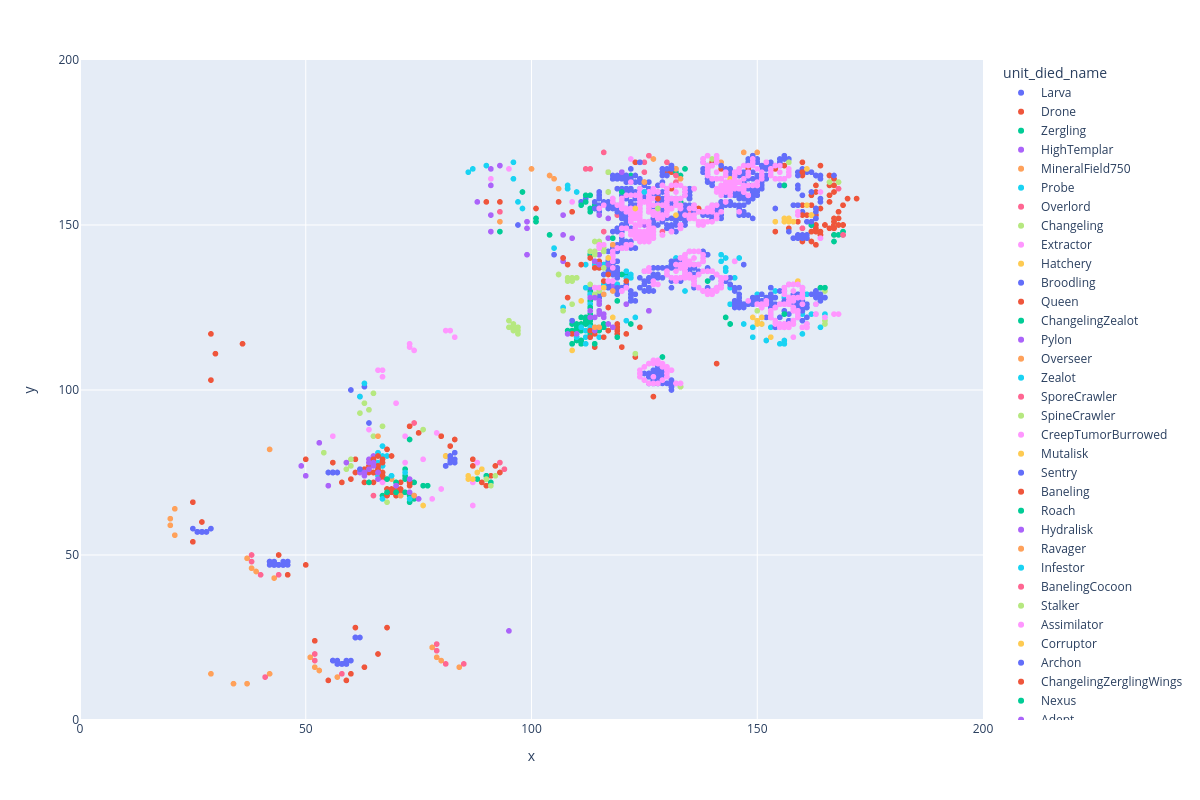

In [32]:
unit_died_test1 = (
    unit_died_df.filter(pl.col("ext_fs_replay_sha256") == latest_replay_digest)
    .select(["unit_died_name", "x", "y"])
    .collect()
)
fig = px.scatter(
    unit_died_test1,
    x="x",
    y="y",
    color="unit_died_name",
    width=1200,
    height=800,
    range_x=(0, 200),
    range_y=(0, 200),
)
fig.show(renderer="png")

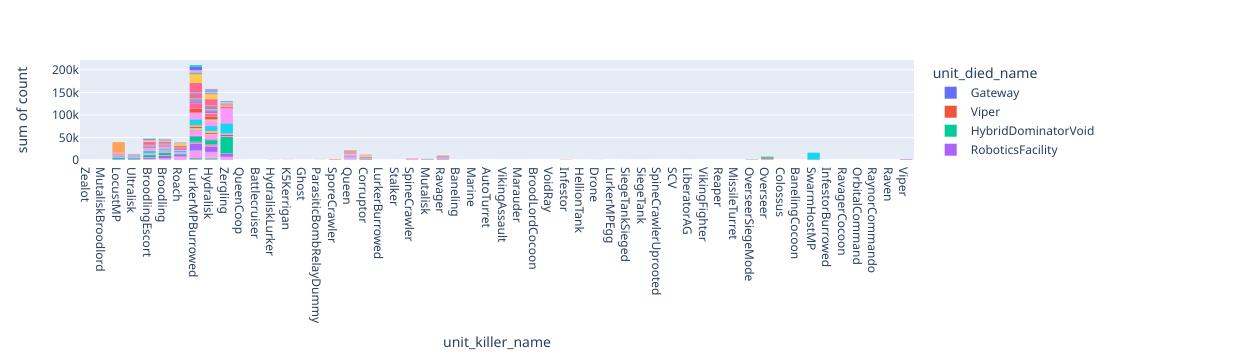

In [68]:
unit_died_ec_le = (
    unit_died_df.join(details_df, on="ext_fs_replay_sha256", how="inner")
    .filter(
        (pl.col("ext_replay_detail_killer_player_name") == my_username)
        & (pl.col("unit_killer_name") != "")
        & (pl.col("unit_died_name") != "InvisibleTargetDummy")
    )
    .select(
        [
            pl.col("ext_replay_detail_killer_player_name"),
            pl.col("unit_died_name"),
            pl.col("unit_tag_index"),
            pl.col("unit_killer_name"),
            pl.col("killer_unit_tag_index"),
            pl.col("ext_replay_loop"),
            pl.col("ext_replay_seconds"),
        ]
    )
)
unit_killer_to_died_freq = (
    unit_died_ec_le.group_by(["unit_killer_name", "unit_died_name"])
    .agg(pl.count().alias("count"))
    .collect()
    .sort("count")
)
unit_killer_freq = (
    unit_died_ec_le.group_by(["unit_killer_name"])
    .agg(pl.count().alias("count"))
    .collect()
    .sort("count")
)
unit_died_freq = (
    unit_died_ec_le.group_by(["unit_died_name"])
    .agg(pl.count().alias("count"))
    .collect()
    .sort("count")
)
hist = px.histogram(
    unit_killer_to_died_freq, x="unit_killer_name", y="count", color="unit_died_name"
)
# Q: What is the unit that kills other units the most across all my game history?
# A: LurkerMPBurrowed killed 21k marines:

hist.show(renderer="png")
# unit_killer_pie = px.pie(unit_killer_freq, names="unit_killer_name", values="count")
# unit_killer_pie.show()

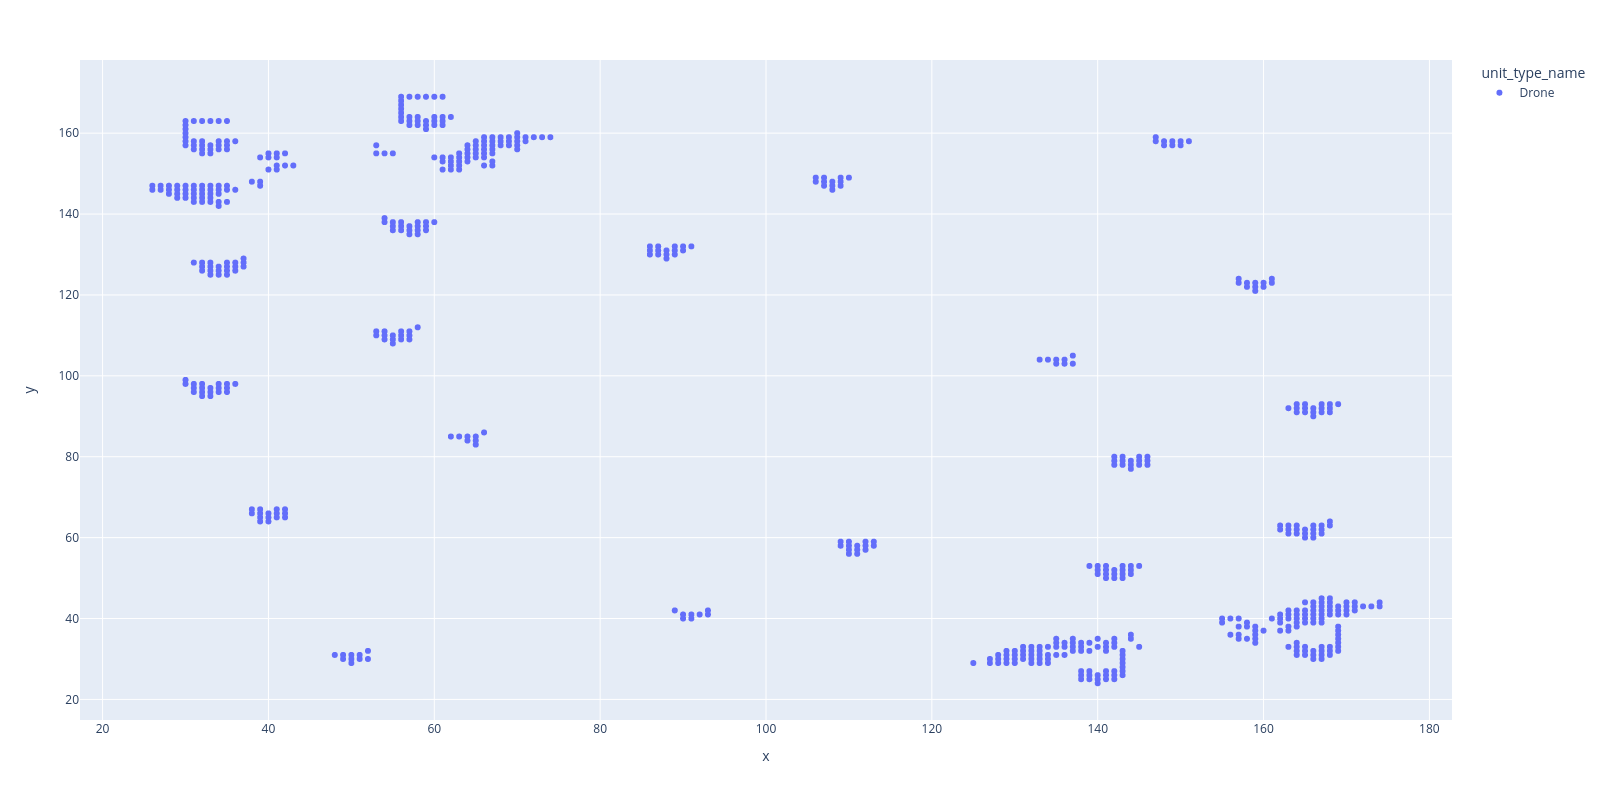

In [67]:
unit_born_ec_le = (
    unit_born_df.join(details_df, on="ext_fs_replay_sha256", how="inner")
    .filter(
        (pl.col("ext_replay_detail_player_name") == my_username)
        & (pl.col("title") == "Emerald City LE")
        & (pl.col("unit_type_name") == "Drone")
    )
    .select([pl.col("x"), pl.col("y"), pl.col("unit_type_name")])
    .group_by(["x", "y", "unit_type_name"])
    .agg(pl.sum("unit_type_name").alias("count"))
    .collect()
)
fig = px.scatter(
    unit_born_ec_le,
    x="x",
    y="y",
    color="unit_type_name",
    render_mode="svg",
    width=1600,
    height=800,
)
fig.show(renderer="png")

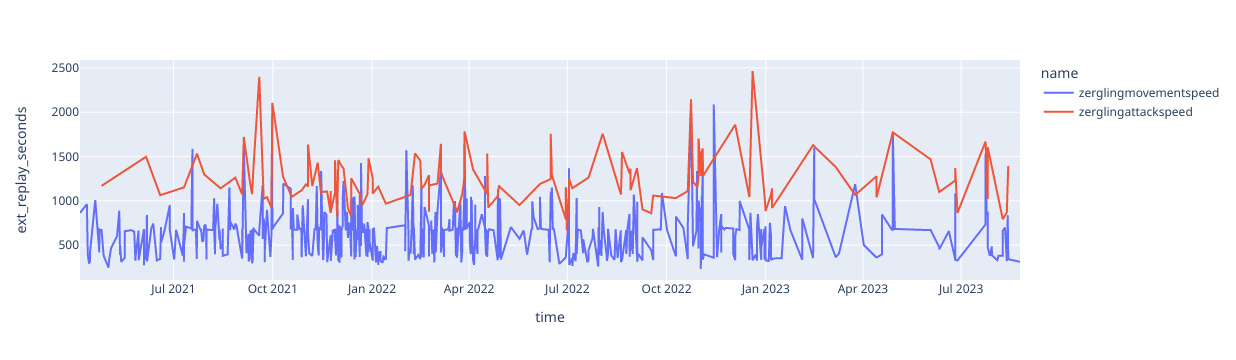

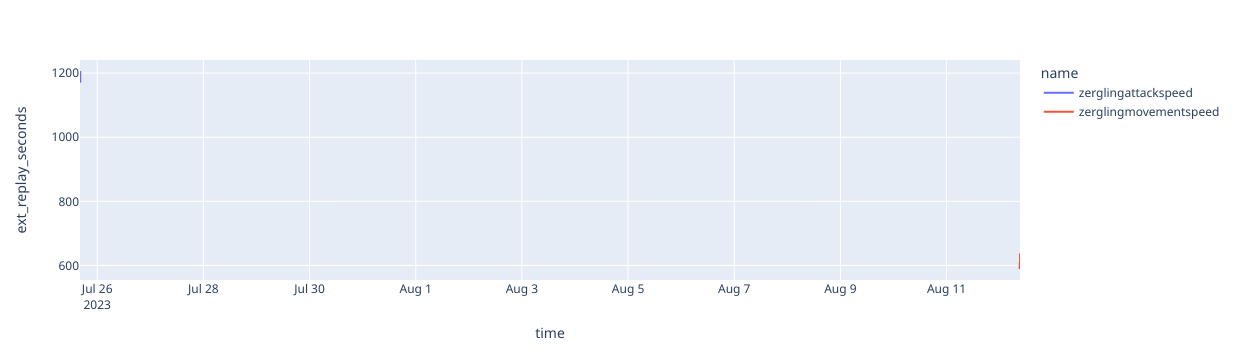

In [88]:
details_df = pl.scan_ipc("/home/seb/git/s2protocol-rs/ipcs/details.ipc")
upgrades_df = pl.scan_ipc("/home/seb/git/s2protocol-rs/ipcs/upgrades.ipc")
y = (
    (
        upgrades_df.join(details_df, on=[pl.col("ext_fs_replay_sha256")])
        .filter(
            (pl.col("ext_replay_seconds").gt(0))
            & (pl.col("name").str.starts_with("zerg"))
            & (pl.col("ext_replay_detail_player_name") == "2-1-8459957-Sazed")
        )
        .select(
            [
                pl.col("name"),
                pl.col("ext_datetime").alias("time"),
                pl.col("ext_replay_seconds").cast(pl.Float64),
            ]
        )
    )
    .collect()
    .sort("time")
)
from functime.plotting import plot_comet, plot_forecasts, plot_fva, plot_residuals

# y.shape
# y

entity_col, time_col = y.columns[:2]
y_train, y_test = y.pipe(train_test_split(test_size=3))
forecaster = linear_model(freq="1mo", lags=24)
forecaster.fit(y=y_train)
y_pred = forecaster.predict(fh=3)
fig = px.line(y, x="time", y="ext_replay_seconds", color="name")
fig.show()
fig = px.line(y_pred, x="time", y="ext_replay_seconds", color="name")
fig.show()
y_pred = linear_model(freq="1mo", lags=24)(y=y_train, fh=3)

# Score forecasts in parallel
scores = mase(y_true=y_test, y_pred=y_pred, y_train=y_train)

# Forecast with target transforms and feature transforms
forecaster = linear_model(
    freq="1mo",
    lags=24,
    target_transform=scale(),
    feature_transform=add_fourier_terms(sp=12, K=6),
)

# Forecast with exogenous regressors!
# Just pass them into X
X = y.select([entity_col, time_col]).pipe(add_fourier_terms(sp=12, K=6)).collect()
X_train, X_future = y.pipe(train_test_split(test_size=3))
forecaster = linear_model(freq="1mo", lags=24)
forecaster.fit(y=y_train, X=X_train)
y_pred = forecaster.predict(fh=3, X=X_future)

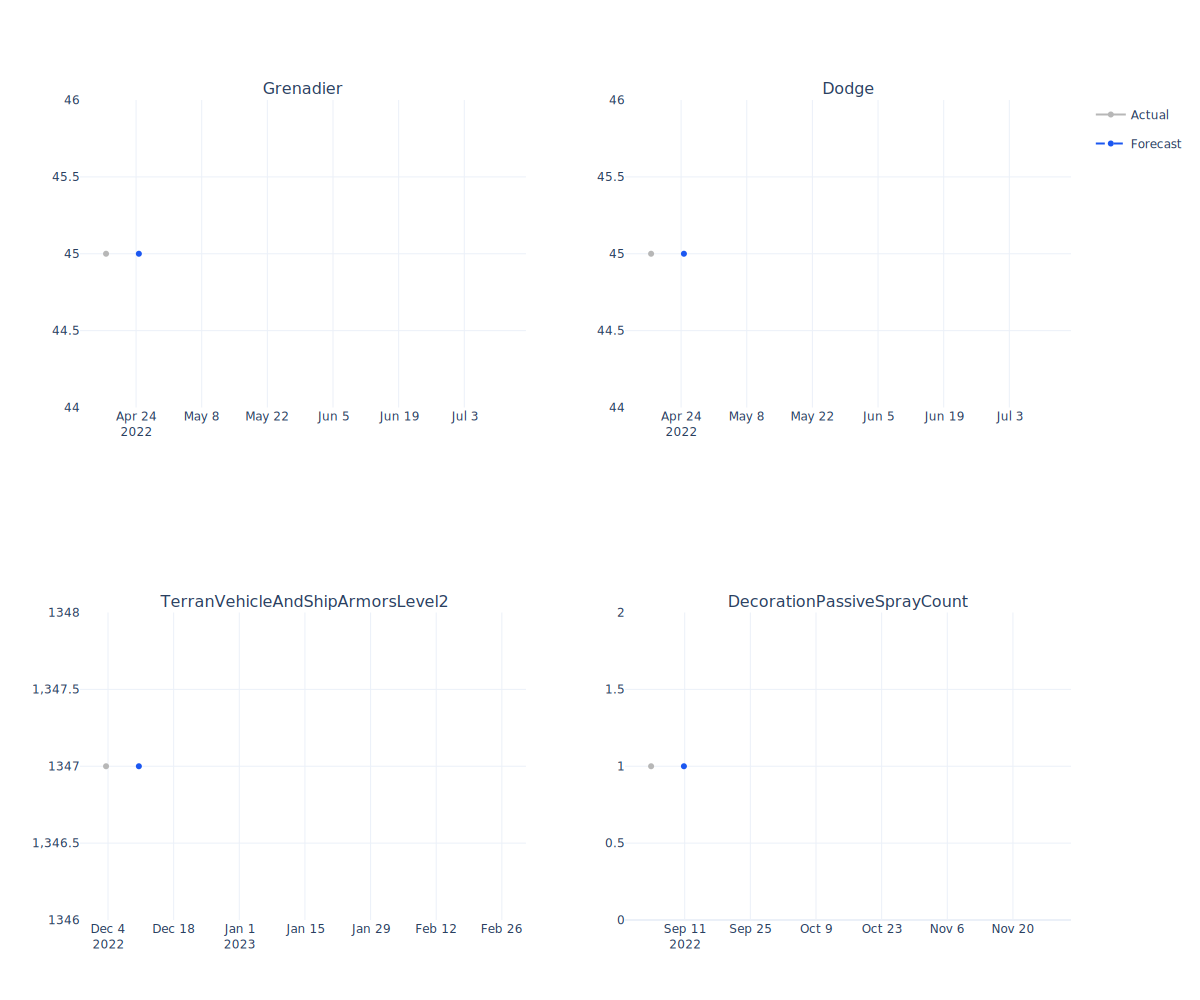

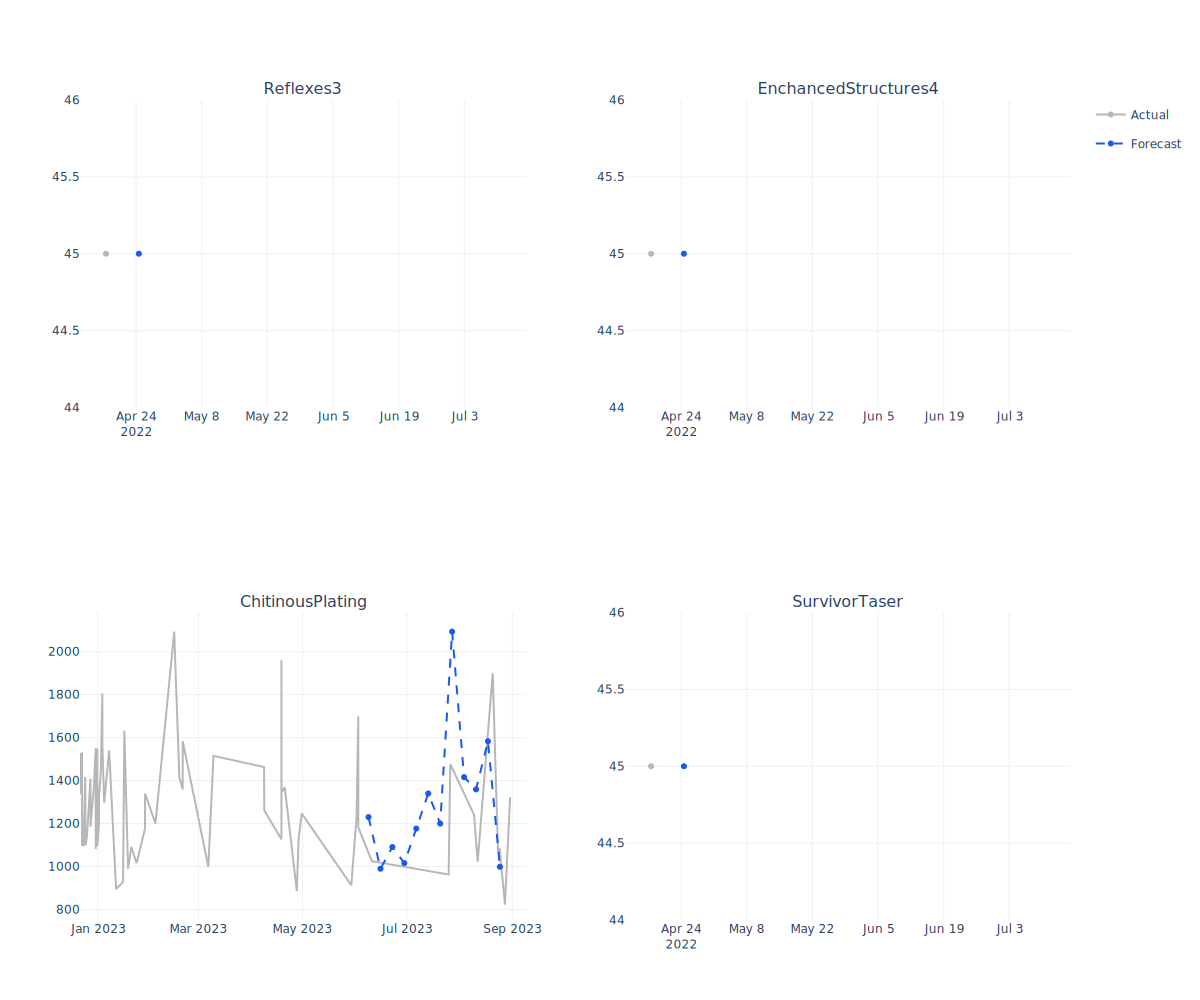

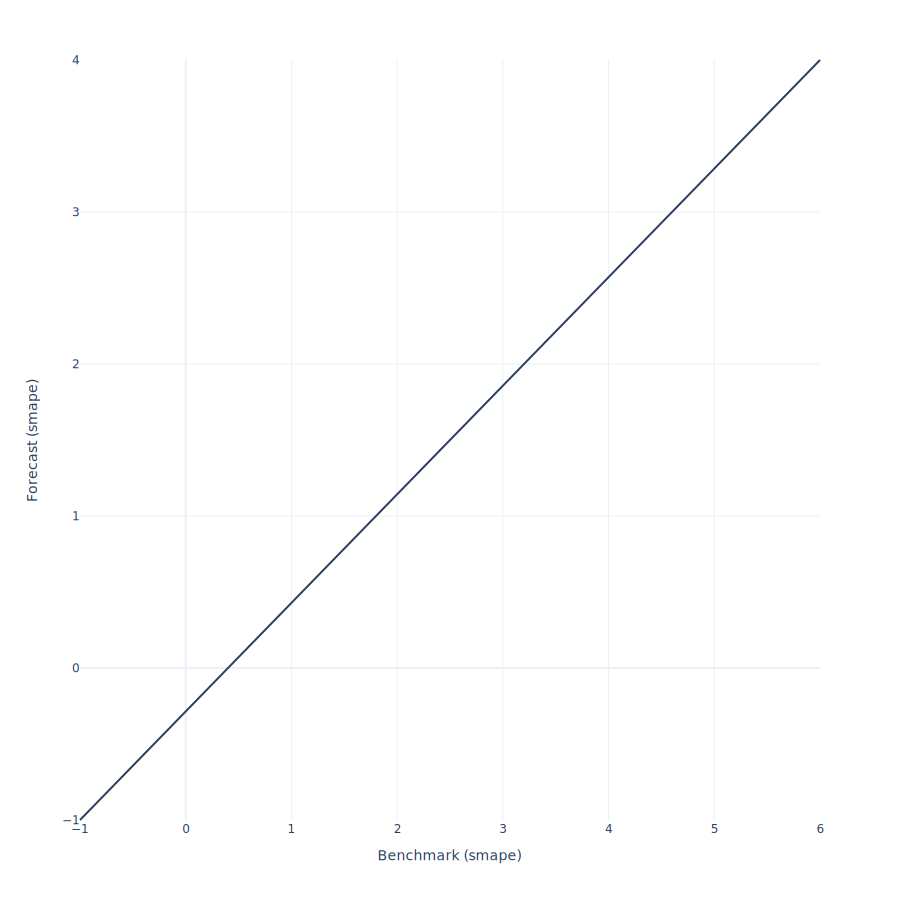

In [215]:
from functime.cross_validation import train_test_split
from functime.evaluation import rank_fva, rank_point_forecasts, rank_residuals
from functime.forecasting import lightgbm, snaive
from functime.plotting import plot_comet, plot_forecasts, plot_fva, plot_residuals
from functime.preprocessing import detrend

details_df = pl.scan_ipc("/home/seb/git/s2protocol-rs/ipcs/details.ipc")
upgrades_df = pl.scan_ipc("/home/seb/git/s2protocol-rs/ipcs/upgrades.ipc")
details_df_exp = (
    details_df.explode("player_list")
    .unnest("player_list")
    .filter(pl.col("name").str.ends_with("Sazed"))
    .select(
        [
            pl.col("working_set_slot_id") + 1,
            pl.col("ext_fs_replay_sha256"),
            pl.col("ext_datetime"),
        ]
    )
)
y = (
    upgrades_df.join(
        details_df_exp,
        left_on=[
            pl.col("ext_fs_replay_sha256"),
            pl.col("player_id"),
        ],
        right_on=[
            pl.col("ext_fs_replay_sha256"),
            pl.col("working_set_slot_id"),
        ],
    )
    .filter((pl.col("ext_replay_seconds").gt(0)) & (pl.col("name") != "SprayZerg"))
    .select(
        [
            pl.col("name"),
            pl.col("ext_datetime").alias("time"),
            pl.col("ext_replay_seconds").cast(pl.Float64),
        ]
    )
    .sort("time")
    .collect()
)
fh = 12
entity_col = y.columns[0]
y_train, y_test = train_test_split(test_size=fh, eager=True)(y)
y.select(
    pl.all().exclude("ext_replay_seconds").n_unique(),
    pl.col("time").min().dt.date().alias("start"),
    pl.col("time").max().dt.date().alias("end"),
)
y_pred_bench = snaive(freq="1w", sp=24)(y=y_train, fh=fh)
y_pred_bench.head()

selected_entities = ranks.head(4).get_column(entity_col).unique()
figure = plot_forecasts(
    y_true=y.filter(pl.col(entity_col).is_in(selected_entities)),
    y_pred=y_pred_bench.filter(pl.col(entity_col).is_in(selected_entities)),
    n_cols=2,
    height=1000,
    width=1200,
)
figure.show(renderer="svg")
ranks = rank_point_forecasts(y_true=y_test, y_pred=y_pred_bench, descending=True)
ranks.head()
selected_entities = ranks.head(4).get_column(entity_col).unique()
figure = plot_forecasts(
    y_true=y.filter(pl.col(entity_col).is_in(selected_entities)),
    y_pred=y_pred_bench.filter(pl.col(entity_col).is_in(selected_entities)),
    n_cols=2,
    height=1000,
    width=1200,
)
figure.show(renderer="svg")
figure = plot_fva(
    y_true=y_test, y_pred=y_pred, y_pred_bench=y_pred_bench, height=900, width=900
)
figure.show(renderer="svg")

In [190]:
details_df = pl.scan_ipc("/home/seb/git/s2protocol-rs/ipcs/details.ipc")
upgrades_df = pl.scan_ipc("/home/seb/git/s2protocol-rs/ipcs/upgrades.ipc")

y = (
    upgrades_df.join(
        details_df_exp,
        left_on=[
            pl.col("ext_fs_replay_sha256"),
            pl.col("player_id"),
        ],
        right_on=[
            pl.col("ext_fs_replay_sha256"),
            pl.col("working_set_slot_id"),
        ],
    )
    .filter((pl.col("ext_replay_seconds").gt(0)) & (pl.col("name") != "SprayZerg"))
    .select(
        [
            pl.col("name"),
            pl.col("ext_datetime").alias("time"),
            pl.col("ext_replay_seconds").cast(pl.Float64),
        ]
    )
    .sort("time")
    .collect()
)

commodity_type,time,price
str,datetime[ns],f64
"""Aluminum""",1960-01-01 00:00:00,511.47
"""Aluminum""",1960-02-01 00:00:00,511.47
"""Aluminum""",1960-03-01 00:00:00,511.47
"""Aluminum""",1960-04-01 00:00:00,511.47
"""Aluminum""",1960-05-01 00:00:00,511.47
"""Aluminum""",1960-06-01 00:00:00,511.47
"""Aluminum""",1960-07-01 00:00:00,511.47
"""Aluminum""",1960-08-01 00:00:00,511.47
"""Aluminum""",1960-09-01 00:00:00,511.47
